[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cahemobu97/AI4ENG/blob/main/02_Modelo_Hipotiroidismo.ipynb)


**`Esta primera parte del proyecto consta del análisis exploratorio de los datos, con el fin de entender la información que se tienen del dataset y poder darle el mejor manejo para cumplir con los requermientos que se piden en el proyecto.`**


In [140]:
#En este primer paso vamos a importar las librerias necesarias para hacer la exploración de datos
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import json
#Importacion de Bibliotecas de Machine Learning
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn import utils
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,KFold,GroupKFold
import lightgbm as lgb
import gc


import warnings
warnings.filterwarnings('ignore')

# For building our model
import keras
from keras.models import Sequential
from keras.layers import Dense

In [141]:
# Cargando credenciales de Kaggel
data = {"username": "carloshernanm", "key": "c4e8b9a467c0efe0b0d0495e83185ba1"}
with open('kaggle.json', 'w') as file:
    json.dump(data, file, indent=4)

!cp kaggle.json ~/.kaggle/



In [142]:
# Se descarga el dataset
!kaggle datasets download -d emmanuelfwerr/thyroid-disease-data

# Se descomprime el dataset
!unzip thyroid-disease-data.zip

thyroid-disease-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  thyroid-disease-data.zip
replace thyroidDF.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: thyroidDF.csv           


In [143]:
#Verificamos que se este funcionando la conexión de la API
!kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/world-population-dataset                     World Population Dataset                             17KB  2022-08-31 11:20:04          10752        325  1.0              
pantanjali/unemployment-dataset                                Unemployment dataset                                 17KB  2022-09-08 08:26:10           2925         81  1.0              
harshsingh2209/tesla-stock-pricing-20172022                    TESLA stock pricing (2017-2022)                      28KB  2022-09-18 14:56:29            490         23  1.0              
thedevastator/airplane-crashes-and-fatalities                  Ai

In [144]:
#Vamos a leer los datos que tiene el dataset para empezar con el análisis explorartorio
df = pd.read_csv("thyroidDF.csv")
df.head(10)

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
0,29,F,f,f,f,f,f,f,f,t,...,NaN,f,NaN,f,NaN,f,NaN,other,-,840801013
1,29,F,f,f,f,f,f,f,f,f,...,128.0,f,NaN,f,NaN,f,NaN,other,-,840801014
2,41,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,11.0,other,-,840801042
3,36,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-,840803046
4,32,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,36.0,other,S,840803047
5,60,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,26.0,other,-,840803048
6,77,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,t,21.0,other,-,840803068
7,28,F,f,f,f,f,f,f,f,f,...,116.0,f,NaN,f,NaN,f,NaN,SVI,-,840807019
8,28,F,f,f,f,f,f,f,f,f,...,76.0,f,NaN,f,NaN,f,NaN,other,-,840808060
9,28,F,f,f,f,f,f,f,f,f,...,83.0,f,NaN,f,NaN,f,NaN,other,-,840808073


In [145]:
df.describe()

,age,TSH,T3,TT4,T4U,FTI,TBG,patient_id
count,9172.000000,8330.000000,6568.000000,8730.000000,8363.000000,8370.000000,349.000000,9.172000e+03
mean,73.555822,5.218403,1.970629,108.700305,0.976056,113.640746,29.870057,8.529473e+08
std,1183.976718,24.184006,0.887579,37.522670,0.200360,41.551650,21.080504,7.581969e+06
min,1.000000,0.005000,0.050000,2.000000,0.170000,1.400000,0.100000,8.408010e+08
25%,37.000000,0.460000,1.500000,87.000000,0.860000,93.000000,21.000000,8.504090e+08
50%,55.000000,1.400000,1.900000,104.000000,0.960000,109.000000,26.000000,8.510040e+08
75%,68.000000,2.700000,2.300000,126.000000,1.065000,128.000000,31.000000,8.607110e+08
max,65526.000000,530.000000,18.000000,600.000000,2.330000,881.000000,200.000000,8.701190e+08


In [146]:
#Buscamos los valores de edad mayores a 100
df[df.age > 100]

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,target,patient_id
2976,455,F,f,f,f,f,f,f,f,f,...,118.0,t,1.13,t,104.0,f,NaN,SVI,-,850530001
5710,65511,M,f,f,f,f,f,f,f,f,...,113.0,t,1.08,t,104.0,f,NaN,other,-,860210008
6392,65512,M,f,f,f,f,f,f,f,f,...,112.0,t,0.84,t,133.0,f,NaN,other,-,860403050
8105,65526,F,f,f,f,f,f,f,f,f,...,132.0,t,1.02,t,129.0,f,NaN,other,-,861014041


In [147]:
#Cambiamos los valores de edad mayores a 100 por valores null
df['age'] = np.where((df.age > 100), np.nan, df.age)
df.describe()

,age,TSH,T3,TT4,T4U,FTI,TBG,patient_id
count,9168.000000,8330.000000,6568.000000,8730.000000,8363.000000,8370.000000,349.000000,9.172000e+03
mean,52.099695,5.218403,1.970629,108.700305,0.976056,113.640746,29.870057,8.529473e+08
std,18.910296,24.184006,0.887579,37.522670,0.200360,41.551650,21.080504,7.581969e+06
min,1.000000,0.005000,0.050000,2.000000,0.170000,1.400000,0.100000,8.408010e+08
25%,37.000000,0.460000,1.500000,87.000000,0.860000,93.000000,21.000000,8.504090e+08
50%,55.000000,1.400000,1.900000,104.000000,0.960000,109.000000,26.000000,8.510040e+08
75%,67.000000,2.700000,2.300000,126.000000,1.065000,128.000000,31.000000,8.607110e+08
max,97.000000,530.000000,18.000000,600.000000,2.330000,881.000000,200.000000,8.701190e+08


In [148]:
df.columns#Vamos a indentificar las columnas de interes para hacer el análisis, en este caso como tenemos tantas columnas,
#vamos a basar el análisis en enfermedad de hipotiroidismo e hipertiroidismo (query_hypothyroid) (query_hyperthyroid)

Index(['age', 'sex', 'on_thyroxine', 'query_on_thyroxine',
       'on_antithyroid_meds', 'sick', 'pregnant', 'thyroid_surgery',
       'I131_treatment', 'query_hypothyroid', 'query_hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH_measured', 'TSH',
       'T3_measured', 'T3', 'TT4_measured', 'TT4', 'T4U_measured', 'T4U',
       'FTI_measured', 'FTI', 'TBG_measured', 'TBG', 'referral_source',
       'target', 'patient_id'],
      dtype='object')

In [149]:
df.shape

(9172, 31)

Como podemos observar en nuestro dataset, cumplimos con la condición de que existan al menos 5000 instancias y 30 columnas, ya que para nuestro proyecto tenemos 9172 instancias o filas y 31 columnas.

In [150]:
#En este paso vamos a poder observar toda la información relacionada al dataframe que hemos cargado
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9172 entries, 0 to 9171
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  9168 non-null   float64
 1   sex                  8865 non-null   object 
 2   on_thyroxine         9172 non-null   object 
 3   query_on_thyroxine   9172 non-null   object 
 4   on_antithyroid_meds  9172 non-null   object 
 5   sick                 9172 non-null   object 
 6   pregnant             9172 non-null   object 
 7   thyroid_surgery      9172 non-null   object 
 8   I131_treatment       9172 non-null   object 
 9   query_hypothyroid    9172 non-null   object 
 10  query_hyperthyroid   9172 non-null   object 
 11  lithium              9172 non-null   object 
 12  goitre               9172 non-null   object 
 13  tumor                9172 non-null   object 
 14  hypopituitary        9172 non-null   object 
 15  psych                9172 non-null   o

In [151]:
check_for_any_nan= df.isna().any().any()#Vamos a encontrar cuantos valores NaN existen en nuestro dataframe
total_nan_values = df.isna().sum().sum()#Vamos a sumar el total de valores NaN presentes en el dataframe

print("Existen valores en NaN: "+str(check_for_any_nan))
print("Total de valores en NaN: "+str(total_nan_values))

Existen valores en NaN: True
Total de valores en NaN: 14633


Al chequear si existen valores en NaN, podemos ver que si existen y que tenemos 14629 valores en NaN, por lo que si hacemos cuentas, quitan la columan del id del paciente, tendriamos 30 columnas x 9172 filas lo que corresponde a 275,160 datos. Al evaluar cuantos valores NaN tenemos, se puede ver que son 14,629, por lo que este valor total de datos corresponde al 5,316% de datos faltantes respecto al total. Por lo que cumplimos tambien con la otra condición.

In [152]:
df.isnull().sum() #Columnas con valores en NaN

age                       4
sex                     307
on_thyroxine              0
query_on_thyroxine        0
on_antithyroid_meds       0
sick                      0
pregnant                  0
thyroid_surgery           0
I131_treatment            0
query_hypothyroid         0
query_hyperthyroid        0
lithium                   0
goitre                    0
tumor                     0
hypopituitary             0
psych                     0
TSH_measured              0
TSH                     842
T3_measured               0
T3                     2604
TT4_measured              0
TT4                     442
T4U_measured              0
T4U                     809
FTI_measured              0
FTI                     802
TBG_measured              0
TBG                    8823
referral_source           0
target                    0
patient_id                0
dtype: int64

In [153]:
df.isnull().mean() * 100 #Promedio en las columnas con valores en NaN

age                     0.043611
sex                     3.347143
on_thyroxine            0.000000
query_on_thyroxine      0.000000
on_antithyroid_meds     0.000000
sick                    0.000000
pregnant                0.000000
thyroid_surgery         0.000000
I131_treatment          0.000000
query_hypothyroid       0.000000
query_hyperthyroid      0.000000
lithium                 0.000000
goitre                  0.000000
tumor                   0.000000
hypopituitary           0.000000
psych                   0.000000
TSH_measured            0.000000
TSH                     9.180113
T3_measured             0.000000
T3                     28.390754
TT4_measured            0.000000
TT4                     4.819014
T4U_measured            0.000000
T4U                     8.820323
FTI_measured            0.000000
FTI                     8.744003
TBG_measured            0.000000
TBG                    96.194941
referral_source         0.000000
target                  0.000000
patient_id

In [154]:
df_hp= df.groupby('query_hypothyroid').count()["patient_id"]#Cantindad de pacientes que tienen hipotirodismo
#f es false (No tienen hipotiroidismo) y t es true (Si tienen hipotiroidismo)
df_hp

query_hypothyroid
f    8542
t     630
Name: patient_id, dtype: int64

In [155]:
new_dataset = df.drop(['target','referral_source','TBG','patient_id'], axis=1)#Eliminamos las columnas que no nos sirven o que contienen muchos datos vacios, en este caso TBG tiene un 96,19% de datos vacios
new_dataset

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured
0,29.0,F,f,f,f,f,f,f,f,t,...,0.3,f,NaN,f,NaN,f,NaN,f,NaN,f
1,29.0,F,f,f,f,f,f,f,f,f,...,1.6,t,1.9,t,128.0,f,NaN,f,NaN,f
2,41.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,NaN,t
3,36.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,NaN,t
4,32.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,f,NaN,f,NaN,f,NaN,t
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167,56.0,M,f,f,f,f,f,f,f,f,...,NaN,f,NaN,t,64.0,t,0.83,t,77.0,f
9168,22.0,M,f,f,f,f,f,f,f,f,...,NaN,f,NaN,t,91.0,t,0.92,t,99.0,f
9169,69.0,M,f,f,f,f,f,f,f,f,...,NaN,f,NaN,t,113.0,t,1.27,t,89.0,f
9170,47.0,F,f,f,f,f,f,f,f,f,...,NaN,f,NaN,t,75.0,t,0.85,t,88.0,f


In [156]:
new_dataset["query_hypothyroid"].value_counts()#Pacientes que presentan o no hipotiroidismo, 
#f es false (No tienen hipotiroidismo) y t es true (Si tienen hipotiroidismo)

f    8542
t     630
Name: query_hypothyroid, dtype: int64

In [157]:
new_dataset["query_hyperthyroid"].value_counts()#Pacientes que presentan o no hipertiroidismo,
#f es false (No tienen hipertiroidismo) y t es true (Si tienen hipertiroidismo)

f    8521
t     651
Name: query_hyperthyroid, dtype: int64

In [158]:
format_dataset_hypo = new_dataset["query_hypothyroid"].map({"f":0,"t":1})
format_dataset_hypo.value_counts()

0    8542
1     630
Name: query_hypothyroid, dtype: int64

In [159]:
format_dataset_hyper = new_dataset["query_hyperthyroid"].map({"f":0,"t":1})

format_dataset_hyper.value_counts()



0    8521
1     651
Name: query_hyperthyroid, dtype: int64

In [160]:
print("Categorias unicas de la columna 'pregnant'", df['pregnant'].unique())
print("Conteo de categorias de la columna 'pregnant' \n", df["pregnant"].value_counts())

Categorias unicas de la columna 'pregnant' ['f' 't']
Conteo de categorias de la columna 'pregnant' 
 f    9065
t     107
Name: pregnant, dtype: int64


In [161]:
print("Categorias unicas en la columna 'T3 measured'", df['T3_measured'].unique())
print("Conteo de categorias de la columna 'T3 measured' \n", df["T3_measured"].value_counts())

Categorias unicas en la columna 'T3 measured' ['f' 't']
Conteo de categorias de la columna 'T3 measured' 
 t    6568
f    2604
Name: T3_measured, dtype: int64


In [162]:
df_by_sex_count = df.groupby('sex').count()["patient_id"]#Se agrupara por sexo para contar cuantos pacientes femeninos o masculinos existen
print (df_by_sex_count)
print ("El numero total de pacientes que con sexo registrado es: " +str (df_by_sex_count.sum()))#Es el numero total de pacientes registrados con sexo en el dataset


sex
F    6073
M    2792
Name: patient_id, dtype: int64
El numero total de pacientes que con sexo registrado es: 8865


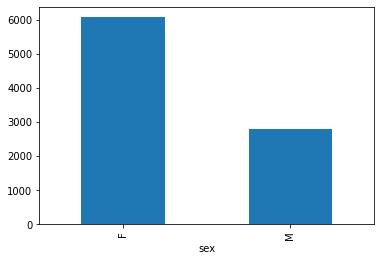

In [163]:
df_by_sex_count = df.groupby('sex').count()["patient_id"].plot(kind='bar')#Grafica de barras para evalular el resultado anterior

In [164]:
#Ahora vamos a hacer una análisis mas profundo de los datos, sacando gráficas que nos permitan interprestar los datos,
#tendremos el promedio de edad por sexo de los pacientes
df_by_sex = df.groupby('sex').mean()["age"]
df_by_sex


sex
F    52.221710
M    52.038351
Name: age, dtype: float64

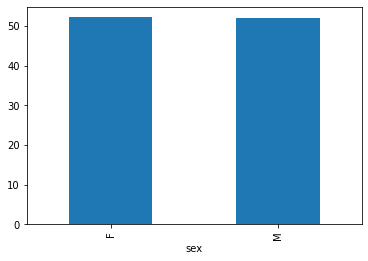

In [165]:
df_by_sex = df.groupby('sex').mean()["age"].plot(kind='bar')#Graficamos el promedio de edad por sexo

In [166]:
# Reemplazamos las columnas categoricas por valores binarios para hacer poder hacer el modelado
dataset = df.replace({'f':0,'t':1, 'y':1, 'n':0, 'M':0, 'F':1})
final_data = dataset.drop(['target','referral_source','TBG'], axis=1) #Se eliminan las columnas que no son de interés

In [167]:
final_data.replace(to_replace='?', inplace=True, value=np.NaN)
final_data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_meds,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,patient_id
0,29.0,1.0,0,0,0,0,0,0,0,1,...,0,NaN,0,NaN,0,NaN,0,NaN,0,840801013
1,29.0,1.0,0,0,0,0,0,0,0,0,...,1,1.9,1,128.0,0,NaN,0,NaN,0,840801014
2,41.0,1.0,0,0,0,0,0,0,0,0,...,0,NaN,0,NaN,0,NaN,0,NaN,1,840801042
3,36.0,1.0,0,0,0,0,0,0,0,0,...,0,NaN,0,NaN,0,NaN,0,NaN,1,840803046
4,32.0,1.0,0,0,0,0,0,0,0,0,...,0,NaN,0,NaN,0,NaN,0,NaN,1,840803047


In [168]:
#Contamos la cantidad de valores que hay null en cada una de las columnas
final_data.isnull().sum()

age                       4
sex                     307
on_thyroxine              0
query_on_thyroxine        0
on_antithyroid_meds       0
sick                      0
pregnant                  0
thyroid_surgery           0
I131_treatment            0
query_hypothyroid         0
query_hyperthyroid        0
lithium                   0
goitre                    0
tumor                     0
hypopituitary             0
psych                     0
TSH_measured              0
TSH                     842
T3_measured               0
T3                     2604
TT4_measured              0
TT4                     442
T4U_measured              0
T4U                     809
FTI_measured              0
FTI                     802
TBG_measured              0
patient_id                0
dtype: int64

Ahora necesitamos convertir las columnas en valores númericos, esto con el fin de ayudarnos a hacer operaciones matemamaticas y estadisticas en las columnas de interes.

In [169]:
# Seleccionamos las columnas de tipo objeto de nuestro dataframe 'object'
columns = final_data.columns[final_data.dtypes.eq('object')]

# Convertimos a valores numericos
final_data[columns] = final_data[columns].apply(pd.to_numeric, errors='coerce')

In [170]:
#Vemos los resultados del proceso
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9172 entries, 0 to 9171
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  9168 non-null   float64
 1   sex                  8865 non-null   float64
 2   on_thyroxine         9172 non-null   int64  
 3   query_on_thyroxine   9172 non-null   int64  
 4   on_antithyroid_meds  9172 non-null   int64  
 5   sick                 9172 non-null   int64  
 6   pregnant             9172 non-null   int64  
 7   thyroid_surgery      9172 non-null   int64  
 8   I131_treatment       9172 non-null   int64  
 9   query_hypothyroid    9172 non-null   int64  
 10  query_hyperthyroid   9172 non-null   int64  
 11  lithium              9172 non-null   int64  
 12  goitre               9172 non-null   int64  
 13  tumor                9172 non-null   int64  
 14  hypopituitary        9172 non-null   int64  
 15  psych                9172 non-null   i

Ahora con los datos previamente organizamos vamos a proceder a visualizar los patrones o tendencias en los datos. Visualizaremos los patrones en diferentes columnas (características) de los datos usando la función hist() de la biblioteca pandas.

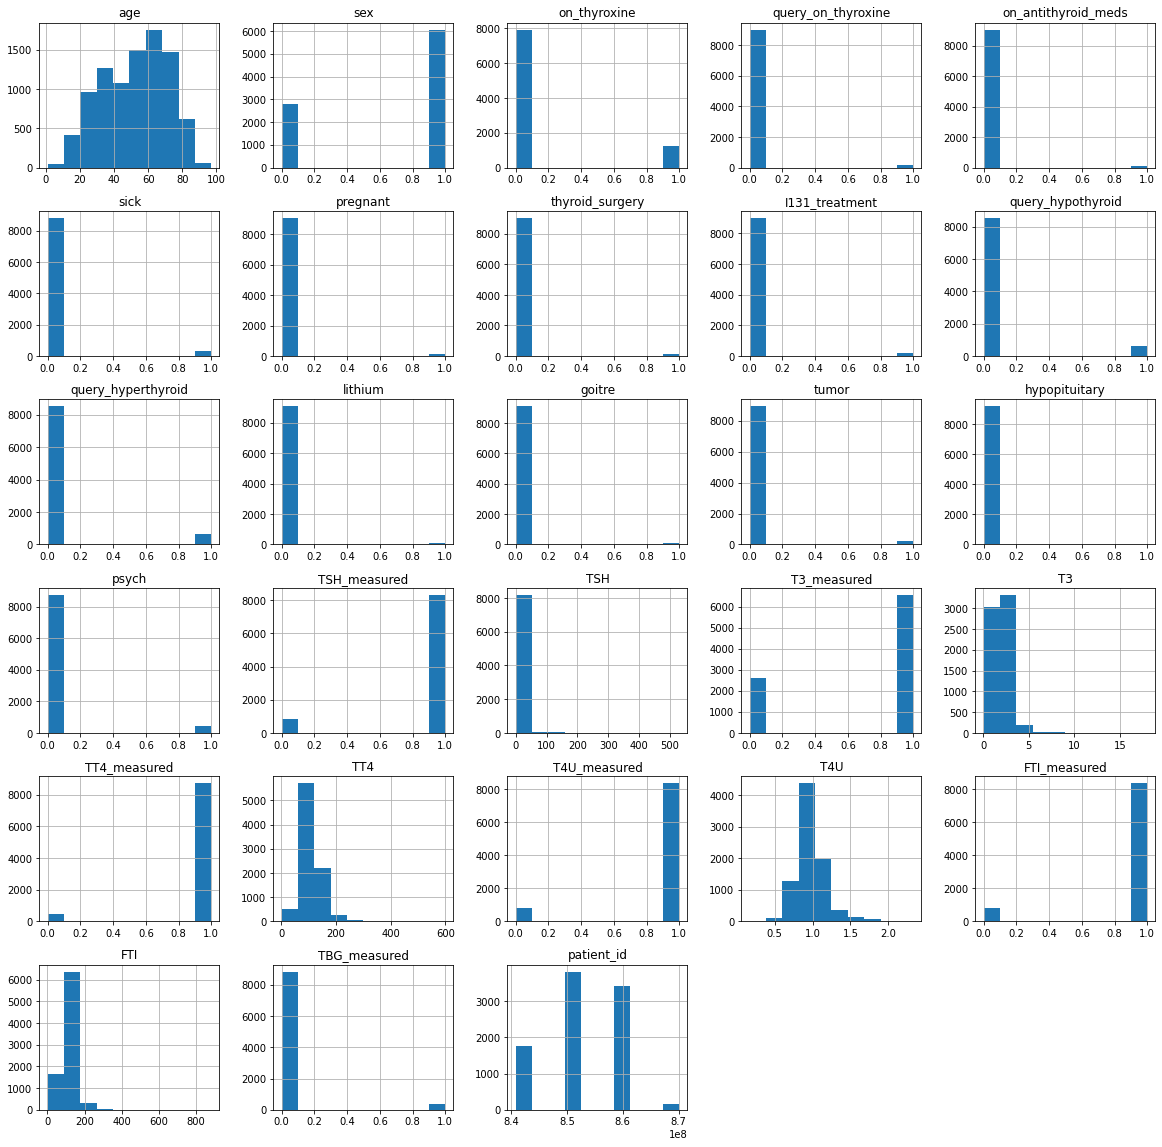

In [171]:
final_data.hist(figsize = (20,20));

Procederemos a reemplazar los valores nulos en nuestros datos con el fin de obtener una métrica estadística apropiada.

In [172]:
# Lista de columnas que contienen valores null
final_data.columns[final_data.isnull().any()].tolist() 

['age', 'sex', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']

In [173]:
#Reemplazamos los valores nulos por la media
final_data['age'].fillna(final_data['age'].mean(), inplace = True)
final_data['T4U'].fillna(final_data['T4U'].mean(), inplace = True)

#Reemplazamos los valores nulos por la mediana
final_data['TSH'].fillna(final_data['TSH'].mean(), inplace = True)
final_data['T3'].fillna(final_data['T3'].median(), inplace = True)
final_data['TT4'].fillna(final_data['TT4'].median(), inplace = True)
final_data['FTI'].fillna(final_data['FTI'].median(), inplace = True)

#Los datos del sexo estan desequilibrados con 0 menor que 1, por eso vamos a 
#sustituir los valores de nulos por 0

final_data['sex'].fillna(0, inplace = True)

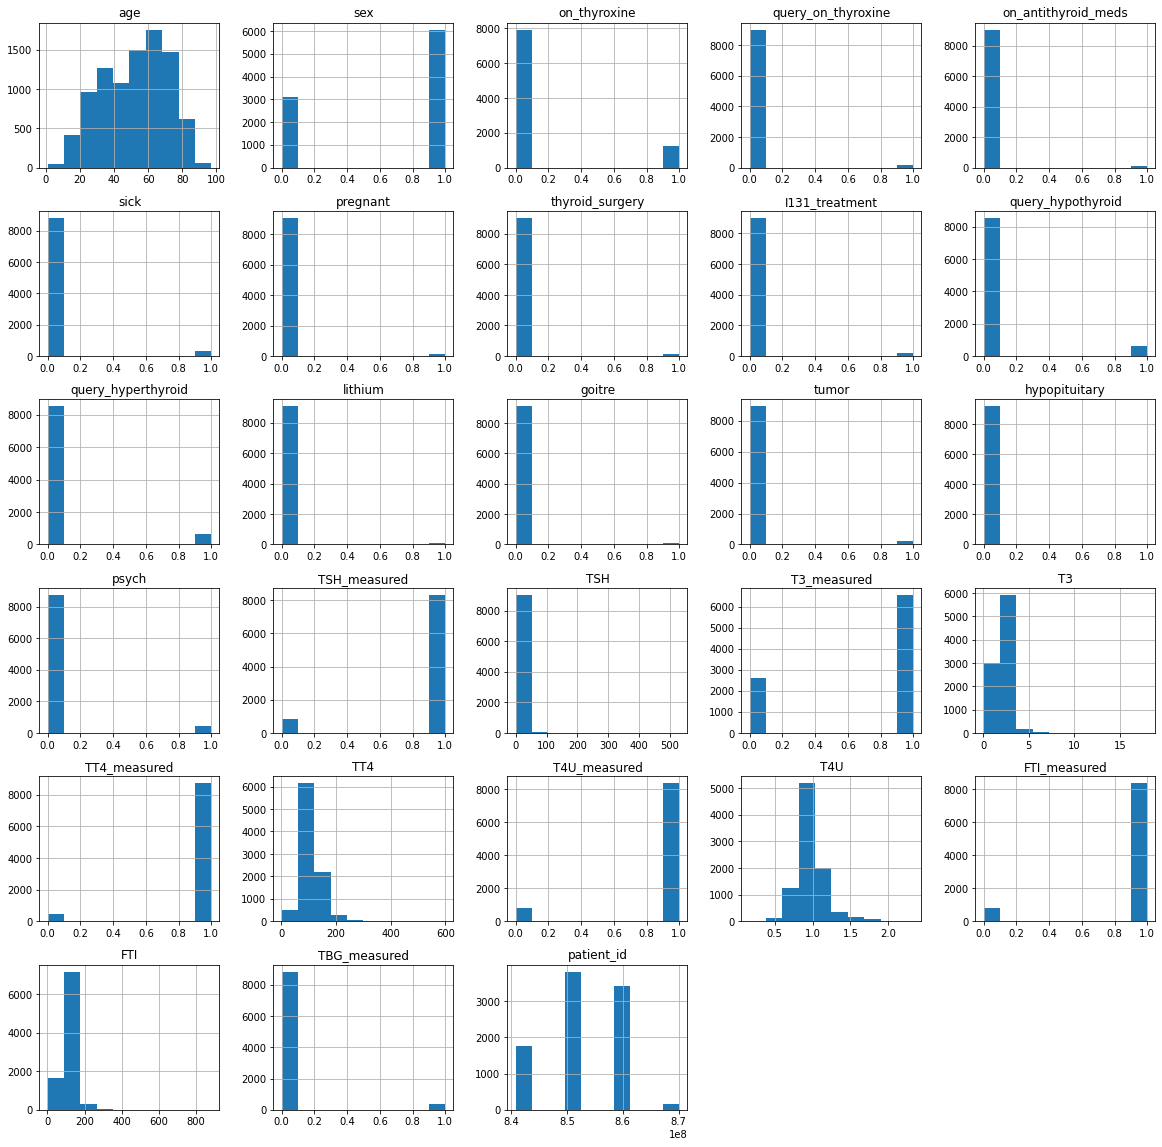

In [174]:
#Graficamos el histograma limpio con las diferentes caracteristicas y los ajustes realizados
plot_cleaned = final_data.hist(figsize = (20,20))

In [175]:
#Chequeamos el numeor de valores nulos
final_data.isnull().sum()

age                    0
sex                    0
on_thyroxine           0
query_on_thyroxine     0
on_antithyroid_meds    0
sick                   0
pregnant               0
thyroid_surgery        0
I131_treatment         0
query_hypothyroid      0
query_hyperthyroid     0
lithium                0
goitre                 0
tumor                  0
hypopituitary          0
psych                  0
TSH_measured           0
TSH                    0
T3_measured            0
T3                     0
TT4_measured           0
TT4                    0
T4U_measured           0
T4U                    0
FTI_measured           0
FTI                    0
TBG_measured           0
patient_id             0
dtype: int64

Modelando los datos
Nuestros datos ahora están limpios y con un formato correcto. Ahora vamos a modelar los datos para la predicción utilizando Deep Learning. Usaremos una red neuronal para predecir el hipotiroidismo (objetivo) en función de nuestros datos de entrada (características).

In [176]:
#Carateristicas
X = final_data.drop('query_hypothyroid', axis = 1) #Seleccionamos todas las columnas, excepto el objetivo
#Variable objetivo
y = final_data['query_hypothyroid']


In [177]:
print(X.shape, y.shape)

(9172, 27) (9172,)



Para evaluar eficientemente nuestro modelo, entrenaremos nuestro modelo en el 80% de los datos y mantendremos el 20% restante para probar el modelo.

In [178]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Escalar los datos ayuda a normalizar los datos dentro de un rango particular y también ayuda a acelerar los cálculos en un algoritmo. Para escalar los datos, usaremos la clase StandardScaler de scikit-learn

In [179]:
from sklearn.preprocessing import StandardScaler

# Iniciar la clase StandarScaler
scaler = StandardScaler()

# Aplicar la clase a los datos test y train
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Tenemos 27 columnas de características debido a las cuales hemos especificado la dimensión de entrada como input_dim=27. Estamos utilizando la función de activación de ReLU en la capa oculta y la función sigmoide para la capa de salida para devolver un valor binario de salida, es decir, hipotiroidismo (1) o negativo (0).

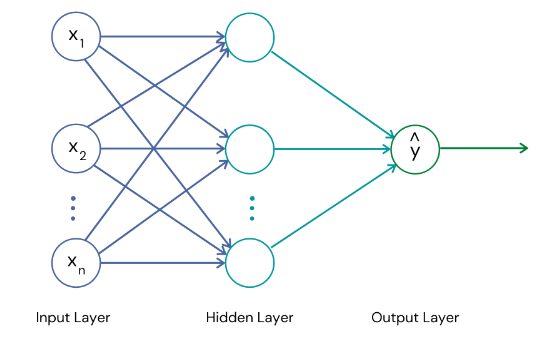

In [180]:
# Entrada
model = Sequential()
# Capa oculta
model.add(Dense(64, kernel_initializer='uniform', input_dim=27, activation='relu'))
# Capa de salida
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))

In [181]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [182]:
# Entrenamos el modelo
result = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=40,  verbose=2)

Epoch 1/100
147/147 - 1s - loss: 0.4271 - accuracy: 0.9283 - val_loss: 0.2359 - val_accuracy: 0.9353 - 893ms/epoch - 6ms/step
Epoch 2/100
147/147 - 0s - loss: 0.2268 - accuracy: 0.9347 - val_loss: 0.2255 - val_accuracy: 0.9353 - 297ms/epoch - 2ms/step
Epoch 3/100
147/147 - 0s - loss: 0.2217 - accuracy: 0.9347 - val_loss: 0.2241 - val_accuracy: 0.9353 - 279ms/epoch - 2ms/step
Epoch 4/100
147/147 - 0s - loss: 0.2194 - accuracy: 0.9347 - val_loss: 0.2240 - val_accuracy: 0.9353 - 292ms/epoch - 2ms/step
Epoch 5/100
147/147 - 0s - loss: 0.2176 - accuracy: 0.9347 - val_loss: 0.2238 - val_accuracy: 0.9353 - 274ms/epoch - 2ms/step
Epoch 6/100
147/147 - 0s - loss: 0.2164 - accuracy: 0.9347 - val_loss: 0.2235 - val_accuracy: 0.9353 - 317ms/epoch - 2ms/step
Epoch 7/100
147/147 - 0s - loss: 0.2151 - accuracy: 0.9347 - val_loss: 0.2236 - val_accuracy: 0.9353 - 295ms/epoch - 2ms/step
Epoch 8/100
147/147 - 0s - loss: 0.2139 - accuracy: 0.9347 - val_loss: 0.2228 - val_accuracy: 0.9353 - 295ms/epoch - 2

In [183]:
#Obtenemos la perdida y la exactitud del modelo evaluado
loss, acc = model.evaluate(X_test, y_test)

# Imprimimos el porcentaje de la perdida y la exactitud obetenido del modelo
print("%s: %.2f%%" % (model.metrics_names[0], loss*100))
print("%s: %.2f%%" % (model.metrics_names[1], acc*100))

58/58 [==============================] - 0s 1ms/step - loss: 0.3739 - accuracy: 0.9155
loss: 37.39%
accuracy: 91.55%


In [184]:
#Predecir las predicciones de salida
y_pred = model.predict(X_test).round()

In [185]:
# Calculamos el porcentaje de F1 score, recall, y precision
print("%s: %.2f%%" % ("F1-score", f1_score(y_test, y_pred)*100))
print("%s: %.2f%%" % ("Recall", recall_score(y_test, y_pred)*100))
print("%s: %.2f%%" % ("Precision", precision_score(y_test, y_pred)*100))

F1-score: 4.91%
Recall: 2.63%
Precision: 36.36%


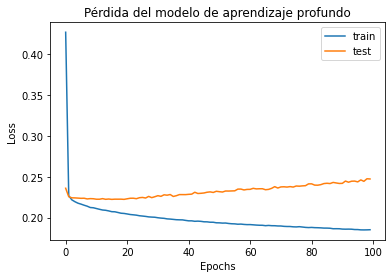

In [186]:
# Resumimos el resultado y graficamos la pérdida de entrenamiento y prueba
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])

#Establecemos los parametros
plt.title('Pérdida del modelo de aprendizaje profundo')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper right')

# Display the plots
plt.show()